# Mini-Batch SGD Assignment

## Instructions:

1. Log onto the serve with port forwarding.
2. Clone this repository (or just pull changes if you already have it).
3. Start Jupyter (don't forget to activate conda).
4. Duplicate this file so that you can still pull changes without merging.
5. Complete the "Questions to Answer."
6. Complete the "Things to Try."

## Questions to Answer

You will answer these questions on gradescope. Try to answer these with your partner prior to running or altering any code.

1. How could you make this code run "stochastic gradient descent (SGD)"?

1. How could you make this code run "batch gradient descent (BGD)"?

1. What is the shape of `train_X`?

1. What is the shape of `train_output`?

1. What values would you expect to see in the `train_output` tensor?

1. What is the shape of `train_Y`?

1. What is the shape of the first linear layer's weight matrix?

1. What is the purpose of the `with torch.no_grad()` ([documentation](https://pytorch.org/docs/stable/generated/torch.no_grad.html#torch.no_grad)) context manager?

1. How do we compute accuracy? Describe what the code is doing.

    ~~~python
    # Convert network output into predictions (one-hot -> number)
    predictions = valid_output.argmax(1)

    # Sum up total number that were correct
    valid_correct += (predictions == valid_Y).type(torch.float).sum().item()
    ~~~

1. What happens when you rerun the training cell for additional epochs without rerunning any other cells?

1. What happens if you set the device to "cpu"?

    ~~~python
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "cpu"
    ~~~

## Things to Try

1. Change the hidden layer activation functions to sigmoid. What were the results?

1. Change the hidden layer activation functions to [something else](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). What were the results?

1. Change the hidden layer activation functions to `nn.Identify`. What were the results?

1. (Optional) Try adding a [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) after each activation function. What were the results?

1. (Optional) Try changing the dataset to either [KMNIST](https://pytorch.org/vision/0.11/datasets.html#kmnist) or [Fashion-MNIST](https://pytorch.org/vision/0.11/datasets.html#fashion-mnist). What were the results?

1. (Optional) Try out the **inference** process.

    1. Save the model. 
    
    ~~~python
    # All training code above
    model_filename = "A05Model.pth"
    torch.save(model.state_dict(), model_filename)
    ~~~
    
    1. Create a new notebook.
    
    1. Load the saved model.
    
    ~~~python
    # Need to bring over some code from the training file to make this work
    model = NeuralNetwork(layer_sizes)
    model.load_state_dict(torch.load(model_filename))
    model.eval()
    
    # Index of a validation example
    i = 0

    # Example input and output
    x, y = valid_loader.dataset[i][0], valid_loader.dataset[i][1]

    with torch.no_grad():
        output = model(x)
        prediction = output[0].argmax(0)
        print(f"Prediction : {prediction}")
        print(f"Target     : {y}")
    ~~~

# Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import pandas as pd

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

## Set Hyperparameters

In [3]:
# Let's use some shared space for the data (so that we don't have copies
# sitting around in each of your home directories)
data_path = "/data/cs152/cache/pytorch/data"

# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Model hyperparameters
neurons_per_layer = [13, 17]

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
activation_function = nn.LeakyReLU

Using 'cuda' device.


## Prepare the MNIST Dataset

In [4]:
def get_mnist_data_loaders(path, batch_size, valid_batch_size=0):

    # MNIST specific transforms
    mnist_mean = (0.1307,)
    mnist_std = (0.3081,)
    mnist_xforms = Compose([ToTensor(), Normalize(mnist_mean, mnist_std)])

    # Training data loader
    train_dataset = MNIST(root=path, train=True, download=True, transform=mnist_xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = MNIST(root=path, train=False, download=True, transform=mnist_xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [5]:
train_loader, valid_loader = get_mnist_data_loaders(data_path, batch_size)

print("Training dataset shape   :", train_loader.dataset.data.shape)
print("Validation dataset shape :", valid_loader.dataset.data.shape)

# Notice that each example is 28x28. These are images

Training dataset shape   : torch.Size([60000, 28, 28])
Validation dataset shape : torch.Size([10000, 28, 28])


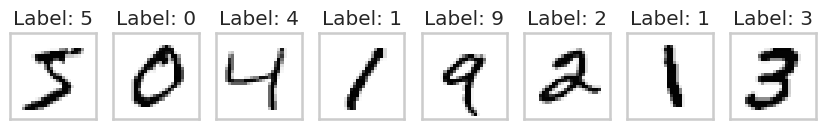

In [6]:
# Let's plot a few images as an example
num_to_show = 8
images = train_loader.dataset.data[:num_to_show]
labels = train_loader.dataset.targets[:num_to_show]

fig, axes = plt.subplots(1, num_to_show)

for axis, image, label in zip(axes, images, labels):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(f"Label: {label}")

In [7]:
# Let's look at the underlying data for a single image
train_loader.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [8]:
# You can almost make out the "5" in the output above
# Let's make it a bit more clear
image = train_loader.dataset.data[0]
image_df = pd.DataFrame(image.squeeze().numpy())
image_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


## Create a Neural Network

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, act_func):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), act_func())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear WITHOUT an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        # Since we've wrapped all layers in nn.Sequential, we just have to
        # call one method and not manually pass the input forward
        return self.layers(X)

In [10]:
# The input layer size depends on the dataset
n0 = train_loader.dataset.data.shape[1:].numel()

# The output layer size depends on the dataset
nL = len(train_loader.dataset.classes)

# Preprend the input and append the output layer sizes
layer_sizes = [n0] + neurons_per_layer + [nL]
model = NeuralNetwork(layer_sizes, activation_function).to(device)

summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-1                  10,205
|    |    └─LeakyReLU: 3-2               --
|    └─Sequential: 2-3                   --
|    |    └─Linear: 3-3                  238
|    |    └─LeakyReLU: 3-4               --
|    └─Linear: 2-4                       180
Total params: 10,623
Trainable params: 10,623
Non-trainable params: 0


## Train Classifier

In [11]:
# A master bar for fancy output progress
mb = master_bar(range(num_epochs))

# Information for plots
mb.names = ["Train Loss", "Valid Loss"]
train_losses = []
valid_losses = []

for epoch in mb:

    #
    # Training
    #
    model.train()

    train_N = len(train_loader.dataset)
    num_train_batches = len(train_loader)
    train_dataiterator = iter(train_loader)

    train_loss_mean = 0

    for batch in progress_bar(range(num_train_batches), parent=mb):

        # Grab the batch of data and send it to the correct device
        train_X, train_Y = next(train_dataiterator)
        train_X, train_Y = train_X.to(device), train_Y.to(device)
        
        print(train_X.shape)
        break;

        # Compute the output
        train_output = model(train_X)

        # Compute loss
        train_loss = criterion(train_output, train_Y)

        num_in_batch = len(train_X)
        tloss = train_loss.item() * num_in_batch / train_N
        train_loss_mean += tloss
        train_losses.append(train_loss.item())

        # Compute partial derivatives
        model.zero_grad()
        train_loss.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

    #
    # Validation
    #
    model.eval()

    valid_N = len(valid_loader.dataset)
    num_valid_batches = len(valid_loader)

    valid_loss_mean = 0
    valid_correct = 0

    with torch.no_grad():

        # valid_loader is probably just one large batch, so not using progress bar
        for valid_X, valid_Y in valid_loader:

            valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

            valid_output = model(valid_X)

            valid_loss = criterion(valid_output, valid_Y)

            num_in_batch = len(valid_X)
            vloss = valid_loss.item() * num_in_batch / valid_N
            valid_loss_mean += vloss
            valid_losses.append(valid_loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = valid_output.argmax(1)

            # Sum up total number that were correct
            valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

    valid_accuracy = 100 * (valid_correct / valid_N)

    # Report information
    tloss = f"Train Loss = {train_loss_mean:.4f}"
    vloss = f"Valid Loss = {valid_loss_mean:.4f}"
    vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
    mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))
    
    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
    graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

torch.Size([256, 1, 28, 28])


ValueError: max() arg is an empty sequence